# "Pythonizing" a Pipeline for AR Visualization: Proof of Concept

In [2]:
#Load needed libraries
#Import needed modules
#general
import astropy.units as u
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#sunpy
import sunpy
from sunpy.net import vso
#solarbextrapolation
from solarbextrapolation.map3dclasses import Map3D
from solarbextrapolation.extrapolators import PotentialExtrapolator
from solarbextrapolation.example_data_generator import generate_example_data, dummyDataToMap
#yt
import yt
#chiantipy
import chianti.core as ch
%matplotlib inline

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/opt/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 found PyQt4 widgets
 using CLI for selections
 reading chiantirc file


It would be nice to have a way to do AR vizualization all in python. To do this we'll need the ability to do the field line extrapolations, visualize the field lines themselves, map the hydrodynamic simulations to the field lines, and then forward model the intensity.

The workflow might look something like this:

* Query HMI database for relevant magnetogram (using `sunpy`)
* Use `solarbextrapolation` module to do the field extrapolation using PFSS
* Using EBTEL (or HYDRAD), do a hydrodynamic calculation for each of the extrapolated field lines
* Using ChiantiPy, forward model the intensity for a given ion (channel?); once we have improvements here, more accurate and instrument specific forward modeling will be possible.
* Map the intensity back to the extrapolated field lines
* Visualize the AR with `yt`

## Querying an HMI Magnetogram

First, create a new client and add filters for collecting the desired data. This part of the notebook follows exactly from the [sample `solarbrextrapolation` notebook courtesy of SunPy and Alex Hamilton](https://github.com/sunpy/solarbextrapolation).

In [3]:
client = vso.VSOClient()

In [4]:
result_hmi = client.query(
    vso.attrs.Time((2011, 2, 14, 20, 34, 0), (2011, 2, 14, 21, 0, 0)),
    vso.attrs.Instrument('HMI'),
    vso.attrs.Physobs('LOS_magnetic_field'),   # Physical observables
    vso.attrs.Sample(4000 * u.s)  
)

Save the query using FITS files.

In [5]:
data_hmi = client.get(result_hmi, methods=('URL-FILE_Rice', 'URL-FILE')).wait()

Next, let's grab the corresponding AIA data.

In [6]:
result_aia = client.query(
    vso.attrs.Time((2011, 2, 14, 20, 34, 0), (2011, 2, 14, 21, 0, 0)), # Time range.
    vso.attrs.Instrument('AIA'),
    vso.attrs.Physobs('intensity'), 
    vso.attrs.Sample(4000 * u.s)    
)

In [7]:
data_aia = client.get(result_aia, methods=('URL-FILE_Rice', 'URL-FILE')).wait()

Peek at both of the resulting maps to see what the results look like.

Exception ignored in: <bound method FITS_rec.__del__ of FITS_rec([(array([84,  0], dtype=int32),), (array([84, 84], dtype=int32),),
       (array([ 84, 168], dtype=int32),), ...,
       (array([      84, 15586947], dtype=int32),),
       (array([      84, 15587031], dtype=int32),),
       (array([      84, 15587115], dtype=int32),)], 
      dtype=(numpy.record, [('COMPRESSED_DATA', '>i4', (2,))]))>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.4/site-packages/astropy/io/fits/fitsrec.py", line 640, in __del__
    del self._coldefs
  File "/opt/anaconda3/lib/python3.4/site-packages/astropy/io/fits/fitsrec.py", line 637, in _coldefs
    raise AttributeError(exc.args[0])
AttributeError: _coldefs
/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
Exception ignored in: <bound method FITS_rec.__del__ of FITS_rec

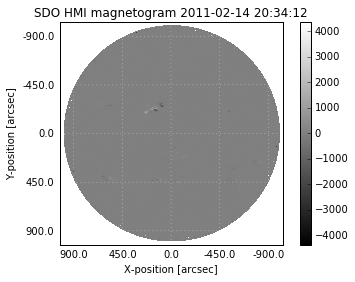

In [10]:
sunpy.map.Map(data_hmi[0]).peek()
hmi_map = sunpy.map.Map(data_hmi[0]).rotate(angle=180.*u.deg)

Exception ignored in: <bound method FITS_rec.__del__ of FITS_rec([(array([1970,    0], dtype=int32),),
       (array([1980, 1970], dtype=int32),),
       (array([1973, 3950], dtype=int32),), ...,
       (array([    2056, 12335860], dtype=int32),),
       (array([    2074, 12337916], dtype=int32),),
       (array([    2050, 12339990], dtype=int32),)], 
      dtype=(numpy.record, [('COMPRESSED_DATA', '>i4', (2,))]))>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.4/site-packages/astropy/io/fits/fitsrec.py", line 640, in __del__
    del self._coldefs
  File "/opt/anaconda3/lib/python3.4/site-packages/astropy/io/fits/fitsrec.py", line 637, in _coldefs
    raise AttributeError(exc.args[0])
AttributeError: _coldefs
/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


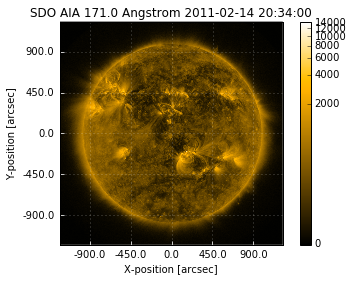

In [11]:
aia_map = sunpy.map.Map(data_aia[0])
aia_map.peek()

Next, let's create a submap around the region of interest. We need to crop both images around the active region.

In [12]:
xrange = u.Quantity([50,    300] * u.arcsec)
yrange = u.Quantity([-350, -100] * u.arcsec)
zrange = u.Quantity([0,     250] * u.arcsec)

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


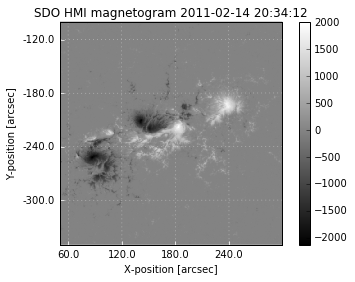

In [13]:
map_hmi_cropped = hmi_map.submap(xrange,yrange)
map_hmi_cropped.peek()

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


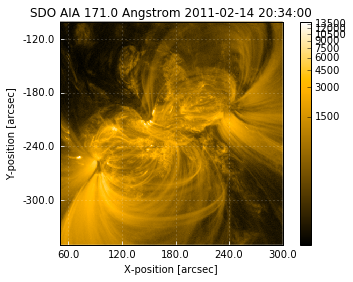

In [14]:
map_aia_cropped = aia_map.submap(xrange,yrange)
map_aia_cropped.peek()

Finally, let's resample the data and have a look at the output.

In [109]:
shape = u.Quantity([100, 100] * u.pixel)
map_hmi_cropped_resampled = map_hmi_cropped.resample(shape, method='linear')
map_aia_cropped_resampled = map_aia_cropped.resample(shape, method='linear')
#map_hmi_cropped_resampled,map_aia_cropped_resampled = map_hmi_cropped,map_aia_cropped

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


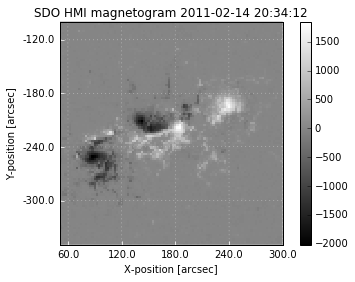

In [110]:
map_hmi_cropped_resampled.peek()

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


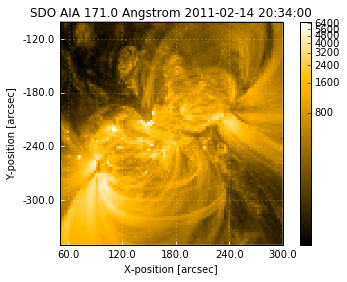

In [111]:
map_aia_cropped_resampled.peek()

## Field Extrapolation
Now that we have the relevant boundary data, we want to perform the field extrapolation with PFSS. 

In [112]:
aPotExt = PotentialExtrapolator(map_hmi_cropped_resampled,zshape=20,zrange=zrange)

In [113]:
aMap3D = aPotExt.extrapolate(enable_numba=True)

False


## Field Line Visualization with `yt`
Now, as a preliminary step, we want to visualize the field lines from the PFSS field extrapolation. First, let's expand the boundary box and recrop the boundary image.

In [114]:
xrangeextended = u.Quantity([ xrange.value[0] - 50, xrange.value[1] + 50 ] * xrange.unit)
yrangeextended = u.Quantity([ yrange.value[0] - 50, yrange.value[1] + 50 ] * yrange.unit)

In [115]:
map_boundary_cropped = hmi_map.submap(xrangeextended,yrangeextended)

/opt/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


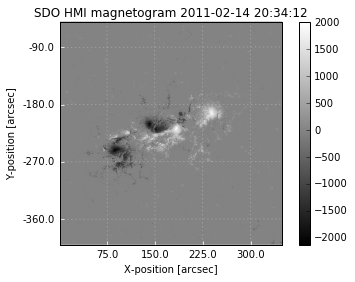

In [116]:
map_boundary_cropped.peek()

Next, we need to reshape the data into something `yt` can load.

In [226]:
data = dict(
    Bx=(aMap3D.data[:,:,:,1],"T"),
    By=(aMap3D.data[:,:,:,0],"T"),
    Bz=(aMap3D.data[:,:,:,2],"T")
)

In [227]:
bbox = np.array([xrangeextended.value,yrangeextended.value,zrange.value])

In [238]:
ds = yt.load_uniform_grid(data,data['Bx'][0].shape,
                          length_unit="cm",bbox=bbox,)

yt : [INFO     ] 2016-07-01 16:52:45,715 Parameters: current_time              = 0.0
yt : [INFO     ] 2016-07-01 16:52:45,716 Parameters: domain_dimensions         = [100 100  20]
yt : [INFO     ] 2016-07-01 16:52:45,718 Parameters: domain_left_edge          = [   0. -400.    0.]
yt : [INFO     ] 2016-07-01 16:52:45,720 Parameters: domain_right_edge         = [ 350.  -50.  250.]
yt : [INFO     ] 2016-07-01 16:52:45,723 Parameters: cosmological_simulation   = 0.0


Let's take a quick look at this new data structure.

yt : [INFO     ] 2016-07-01 16:52:47,455 Loading field plugins.
yt : [INFO     ] 2016-07-01 16:52:47,455 Loaded angular_momentum (8 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,456 Loaded astro (15 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,457 Loaded cosmology (22 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,458 Loaded fluid (64 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,460 Loaded fluid_vector (96 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,461 Loaded geometric (112 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,462 Loaded local (112 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,463 Loaded magnetic_field (120 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,464 Loaded my_plugins (120 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,465 Loaded species (122 new fields)
yt : [INFO     ] 2016-07-01 16:52:47,572 xlim = 0.000000 350.000000
yt : [INFO     ] 2016-07-01 16:52:47,573 ylim = -400.000000 -50.000000
yt : [INFO     ] 2016-07-01 16:52:47,575 xlim = 0.0


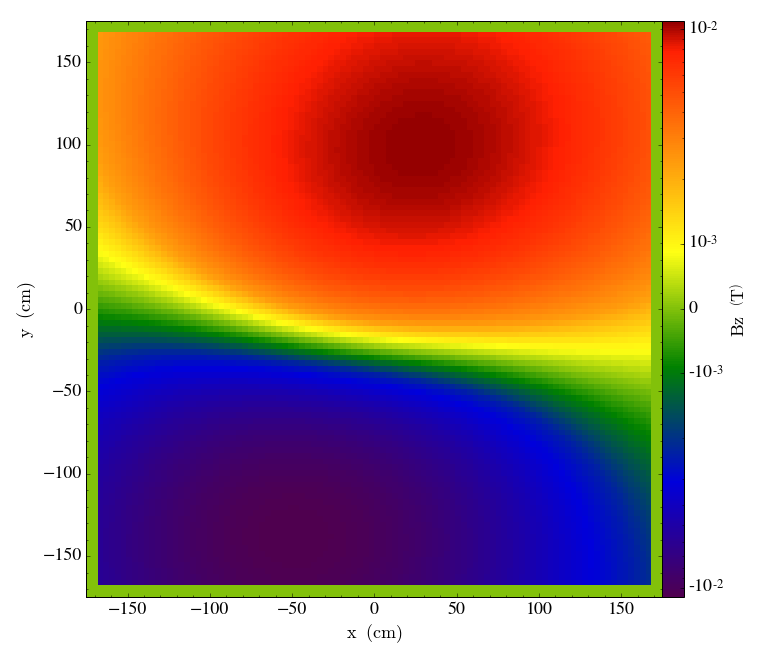

In [239]:
yt.SlicePlot(ds,fields='Bz',axis='z')

The hard part comes in how exactly to calculate the streamlines. Now, we don't really know exactly where to choose the seedpoints. For now, let's just choose them randomly. at a height of $z\approx1$.

In [219]:
c = ds.domain_center
N = 1000
scale = ds.domain_width[0]
#select seed points inside valid domain
i = 0
pos = []
while i < N:   
    pos_dx = np.random.normal(scale=ds.domain_width[0].value,size=(3))
    tmp_pos = c.value+pos_dx
    if (tmp_pos[0:2] > ds.domain_left_edge.value[0:2]).all() and (tmp_pos[0:2] < ds.domain_right_edge.value[0:2]).all():
        pos.append(tmp_pos)
        i += 1
#transform to yt array
pos = pos*ds.domain_width[0]/ds.domain_width.value
#set lower boundary for all seed points
for p in pos:
    p[-1] = 15.

In [220]:
streamlines = yt.visualization.api.Streamlines(ds, pos, 'Bx', 'By', 'Bz',get_magnitude=True)
streamlines.integrate_through_volume()

yt : [INFO     ] 2016-07-01 16:42:25,077 AMRKDTree rebuilt, Final Volume: 3.062500e+07


Plot the fieldlines.

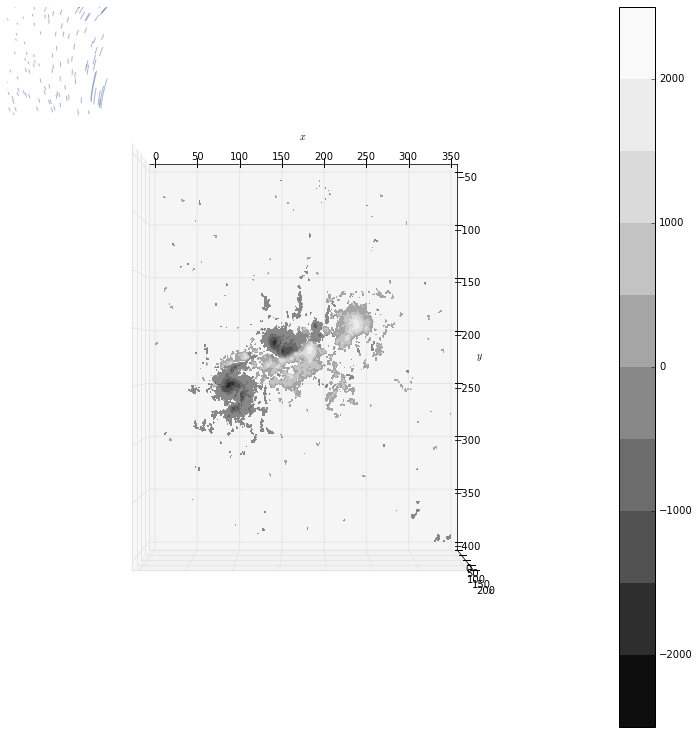

In [221]:
fig=plt.figure(figsize=(10,10))
ax = Axes3D(fig)
#add magnetogram surface
X,Y = np.meshgrid(
    np.linspace(map_boundary_cropped.xrange.value[0],map_boundary_cropped.xrange.value[1],map_boundary_cropped.data.shape[1]),
    np.linspace(map_boundary_cropped.yrange.value[0],map_boundary_cropped.yrange.value[1],map_boundary_cropped.data.shape[0])
)
mg_masked = np.ma.array(map_boundary_cropped.data,mask=np.fabs(map_boundary_cropped.data)<100.)
mg_bound = ax.contourf(X,Y,mg_masked,10,cmap=plt.cm.Greys_r,zdir='z',offset=-10.)
#add fieldlines
for stream in streamlines.streamlines:
    stream = stream[np.all(stream != 0.0, axis=1)]
    if stream[0,2] < 20. and stream[-1,2] < 50.:
        ax.plot3D(stream[:,0], stream[:,1], stream[:,2], alpha=0.5,color=sns.color_palette('deep')[0])
#axes options
ax.set_xlim([0,350])
ax.set_ylim([-400,-50])
ax.set_zlim([0,200])
ax.view_init(elev=90, azim=-90)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$z$')
plt.colorbar(mg_bound)

The next step is to extract all of the field strengths and loop lengths. The problem with the latter though is that all of our units are in arcsec and we want them in cgs length units (i.e. cm or Mm).